# install required libraries

## NOTE: This environment has been installed basic libraries like as torch, jupyter, pandas, numpy, and so on. 

In [1]:
!pip3 install opendatasets transformers pandas-profiling -q

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


# prepare data files and authorize kaggle

In [2]:
import opendatasets as od

od.download('https://www.kaggle.com/c/nlp-getting-started', force=True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: 
Your Kaggle username: 
Your Kaggle username: lamttic
Your Kaggle Key: ········


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 593k/593k [00:00<00:00, 115MB/s]


Extracting archive ./nlp-getting-started/nlp-getting-started.zip to ./nlp-getting-started


In [3]:
!cp ./nlp-getting-started/* .

# Load data files

In [4]:
import pandas as pd
import numpy as np
import torch

sample_df = pd.read_csv('sample_submission.csv')
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

sample_df

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [5]:
train_df.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# preprocess

In [6]:
from transformers import BertForSequenceClassification, BertTokenizer

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [8]:
train_sentences = train_df['text'].values
train_labels = train_df['target'].values
test_sentences = test_df['text'].values

## show frequency of each sentence

(array([  85.,  296.,  445.,  551.,  779.,  973.,  961., 1032., 2334.,
         157.]),
 array([  7.,  22.,  37.,  52.,  67.,  82.,  97., 112., 127., 142., 157.]),
 <BarContainer object of 10 artists>)

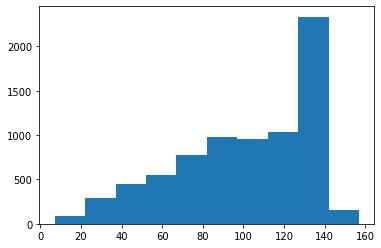

In [9]:
import matplotlib.pyplot as plt

plt.hist([len(sentence) for sentence in train_sentences])

(array([ 35., 111., 153., 218., 272., 408., 388., 386., 755., 537.]),
 array([  5. ,  19.6,  34.2,  48.8,  63.4,  78. ,  92.6, 107.2, 121.8,
        136.4, 151. ]),
 <BarContainer object of 10 artists>)

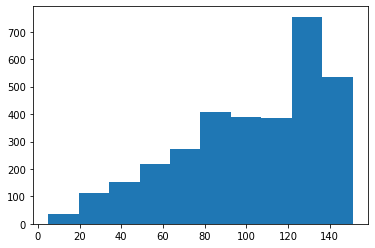

In [10]:
plt.hist([len(sentence) for sentence in test_sentences])

# tokenize

In [11]:
max_length = max([len(sentence) for sentence in np.concatenate([train_sentences, test_sentences], axis=0)])

In [12]:
def encode_sentences(sentences, max_length):
    input_ids = []
    attention_masks = []

    for sentence in sentences:
        encode_dict = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encode_dict['input_ids'])
        attention_masks.append(encode_dict['attention_mask'])
        
    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)

In [13]:
train_input_ids, train_attention_masks = encode_sentences(train_sentences, max_length)

In [14]:
train_labels = torch.tensor(train_labels)

# set dataset and dataloader for train

In [15]:
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

In [16]:
dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)

In [17]:
train_size = int(len(dataset) * 0.9)
val_size = len(dataset) - train_size

In [18]:
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [19]:
batch_size = 16

train_dataloader = DataLoader(train_dataset,
                              sampler=RandomSampler(train_dataset),
                              batch_size=batch_size)
val_dataloader = DataLoader(val_dataset,
                            sampler=SequentialSampler(val_dataset),
                            batch_size=batch_size)

# set pretrained model

In [20]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-cased',
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

# set optimizer

In [21]:
from transformers import AdamW

In [22]:
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# set learning rate scheduler

In [23]:
from transformers import get_linear_schedule_with_warmup

In [24]:
epochs = 4
total_step = len(train_dataset) * epochs

In [25]:
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_step
)

In [26]:
def get_accuracy(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(preds_flat == labels_flat) / len(preds_flat)

In [27]:
import time
import datetime

def format_time(elapsed):
    elapsed_rounded = int(round(elapsed))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [28]:
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        output = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        loss = output[0]
        logits = output[1]
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)          
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in val_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            output = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            loss = output[0]
            logits = output[1]
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += get_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(val_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...


/pytorch/aten/src/ATen/native/cuda/Indexing.cu:702: indexSelectLargeIndex: block: [570,0,0], thread: [96,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
/pytorch/aten/src/ATen/native/cuda/Indexing.cu:702: indexSelectLargeIndex: block: [570,0,0], thread: [97,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
/pytorch/aten/src/ATen/native/cuda/Indexing.cu:702: indexSelectLargeIndex: block: [570,0,0], thread: [98,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
/pytorch/aten/src/ATen/native/cuda/Indexing.cu:702: indexSelectLargeIndex: block: [570,0,0], thread: [99,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
/pytorch/aten/src/ATen/native/cuda/Indexing.cu:702: indexSelectLargeIndex: block: [570,0,0], thread: [100,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
/pytorch/aten/src/ATen/native/cuda/Indexing.cu:702: indexSelectLargeIndex: block: [570,0,0], thread: [101,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
/pytorch/aten/src/ATen/native/cuda/Indexing.cu:702

RuntimeError: CUDA error: CUBLAS_STATUS_ALLOC_FAILED when calling `cublasCreate(handle)`

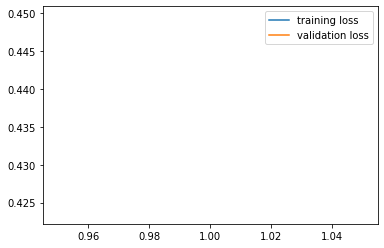

In [32]:
import matplotlib.pyplot as plt
"""
training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
"""
training_loss,validation_loss,validation_accuracy = [],[],[]
for item in training_stats:
    training_loss.append(item['Training Loss'])
    validation_accuracy.append(item['Valid. Accur.'])
    validation_loss.append(item['Valid. Loss'])
plt.plot(range(1,2),training_loss)
plt.plot(range(1,2),validation_loss)
plt.legend(['training loss','validation loss'])

In [45]:
input_ids = []
attention_masks = []

for sentence in test_sentences:
    encode_dict = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids.append(encode_dict['input_ids'])
    attention_masks.append(encode_dict['attention_mask'])

In [46]:
temp_labels = [1]*len(input_ids)

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
temp_labels = torch.tensor(temp_labels)

In [47]:
predict_data = TensorDataset(input_ids, attention_masks, temp_labels)
print(predict_data.tensors)
predict_dataloader = DataLoader(predict_data, sampler=SequentialSampler(predict_data), batch_size=batch_size)

(tensor([[  101,  2074,  3047,  ...,     0,     0,     0],
        [  101,  2657,  2055,  ...,     0,     0,     0],
        [  101,  2045,  2003,  ...,     0,     0,     0],
        ...,
        [  101,  2665,  2240,  ...,     0,     0,     0],
        [  101, 12669,  3314,  ...,     0,     0,     0],
        [  101,  1001,  2103,  ...,     0,     0,     0]]), tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), tensor([1, 1, 1,  ..., 1, 1, 1]))


In [48]:
model.eval()

predictions = []

for batch in predict_dataloader:
    batch = tuple(t.to(device) for t in batch)
    
    b_input_ids, b_attention_masks,b_labels = batch    

    with torch.no_grad():
        outputs = model(b_input_ids,attention_mask=b_attention_masks,token_type_ids=None)
    
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    pred_flatten = np.argmax(logits,axis=1).flatten()

    label_ids = b_labels.to('cpu').numpy()
    label_ids = label_ids.flatten()
    
    predictions.extend(pred_flatten)

In [49]:
import csv

In [50]:
with open('submission.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['id', 'target'])
    for idx, target in zip(test_df['id'].values, predictions):
        writer.writerow([idx, target])

In [51]:
!kaggle competitions submit -c nlp-getting-started -f submission.csv -m "My third try"

100%|██████████████████████████████████████| 25.4k/25.4k [00:07<00:00, 3.37kB/s]
Successfully submitted to Natural Language Processing with Disaster Tweets

In [ ]:
import pandas_profiling